# 61 Exporting Geological Maps and Custom sections from GemPy

## Set File Paths and download Tutorial Data

If you downloaded the latest `GemGIS` version from the Github repository, append the path so that the package can be imported successfully. Otherwise, it is recommended to install `GemGIS` via `pip install gemgis` and import `GemGIS` using `import gemgis as gg`. In addition, the file path to the folder where the data is being stored is set. The tutorial data is downloaded using Pooch (https://www.fatiando.org/pooch/latest/index.html) and stored in the specified folder. Use `pip install pooch` if Pooch is not installed on your system yet.

In [1]:
import gemgis as gg

file_path ='data/61_Exporting_geological_map_and_custom_sections_from_GemPy/'
gg.download_gemgis_data.download_tutorial_data(filename="61_Exporting_geological_map_and_custom_sections_from_GemPy.zip", dirpath=file_path)

C:\Users\ale93371\Anaconda3\envs\gempy_new8\lib\site-packages\gemgis\gemgis.py:27: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


## Loading the data

In [2]:
import geopandas as gpd
import rasterio

interfaces = gpd.read_file(file_path + 'interfaces.shp')
orientations = gpd.read_file(file_path + 'orientations.shp')
extent = [0,972,0,1069, 300, 800]
resolution = [50, 50, 50]

In [3]:
interfaces.head()

,level_0,level_1,formation,X,Y,Z,geometry
0,0,0,Sand1,0.26,264.86,353.97,POINT (0.25633 264.86215)
1,0,0,Sand1,10.59,276.73,359.04,POINT (10.59347 276.73371)
2,0,0,Sand1,17.13,289.09,364.28,POINT (17.13494 289.08982)
3,0,0,Sand1,19.15,293.31,364.99,POINT (19.15013 293.31349)
4,0,0,Sand1,27.80,310.57,372.81,POINT (27.79512 310.57169)


In [4]:
orientations['polarity'] = 1
orientations.head()

,formation,dip,azimuth,X,Y,Z,geometry,polarity
0,Ton,30.50,180.00,96.47,451.56,477.73,POINT (96.47104 451.56362),1
1,Ton,30.50,180.00,172.76,661.88,481.73,POINT (172.76101 661.87650),1
2,Ton,30.50,180.00,383.07,957.76,444.45,POINT (383.07389 957.75787),1
3,Ton,30.50,180.00,592.36,722.70,480.57,POINT (592.35583 722.70229),1
4,Ton,30.50,180.00,766.59,348.47,498.96,POINT (766.58562 348.46907),1


## Creating the GemPy Model

In [5]:
import gempy as gp

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\ale93371\Anaconda3\envs\gempy_new8\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [6]:
geo_model = gp.create_model('Model1')
geo_model

Model1  2023-04-05 13:54

### Initiating the Model

In [7]:
import pandas as pd

gp.init_data(geo_model, extent, resolution,
             surface_points_df = interfaces,
             orientations_df = orientations,
             default_values=True)
geo_model.surfaces

Active grids: ['regular']


,surface,series,order_surfaces,color,id
0,Sand1,Default series,1,#015482,1
1,Ton,Default series,2,#9f0052,2


The vertices and edges are currently NaN values, so no model has been computed so far.

In [8]:
geo_model.surfaces.df

,surface,series,order_surfaces,isBasement,isFault,isActive,hasData,color,vertices,edges,sfai,id
0,Sand1,Default series,1,False,False,True,True,#015482,NaN,NaN,NaN,1
1,Ton,Default series,2,True,False,True,True,#9f0052,NaN,NaN,NaN,2


### Mapping Stack to Surfaces

In [9]:
gp.map_stack_to_surfaces(geo_model,
                         {"Strat_Series": ('Sand1', 'Ton')},
                         remove_unused_series=True)
geo_model.add_surfaces('basement')

,surface,series,order_surfaces,color,id
0,Sand1,Strat_Series,1,#015482,1
1,Ton,Strat_Series,2,#9f0052,2
2,basement,Strat_Series,3,#ffbe00,3


### Loading the Topography

In [10]:
geo_model.set_topography(
    source='gdal', filepath='data/61_Exporting_geological_map_and_custom_sections_from_GemPy/raster1.tif')

Cropped raster to geo_model.grid.extent.
depending on the size of the raster, this can take a while...
storing converted file...
Active grids: ['regular' 'topography']


Grid Object. Values: 
array([[   9.72      ,   10.69      ,  305.        ],
       [   9.72      ,   10.69      ,  315.        ],
       [   9.72      ,   10.69      ,  325.        ],
       ...,
       [ 970.056     , 1059.28181818,  622.0892334 ],
       [ 970.056     , 1063.16909091,  622.06713867],
       [ 970.056     , 1067.05636364,  622.05786133]])

### Defining Custom Section

In [11]:
custom_section = gpd.read_file(file_path + 'customsections1.shp')
custom_section_dict = gg.utils.to_section_dict(custom_section, section_column='section')
geo_model.set_section_grid(custom_section_dict)

Active grids: ['regular' 'topography' 'sections']


,start,stop,resolution,dist
Section1,"[1.372395262185787, 383.9794474025771]","[970.9954955186289, 383.8831909730347]","[100, 80]",969.62


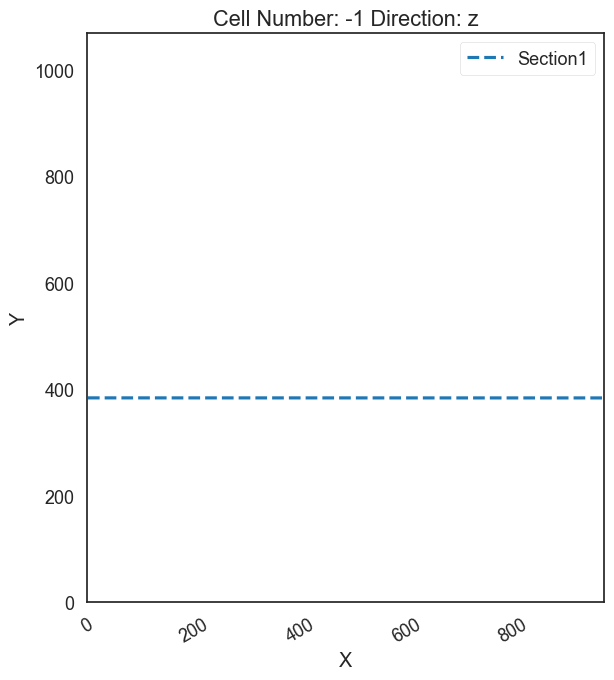

In [12]:
gp.plot.plot_section_traces(geo_model)

### Setting Interpolator

In [13]:
gp.set_interpolator(geo_model,
                    compile_theano=True,
                    theano_optimizer='fast_compile',
                    verbose=[],
                    update_kriging = False
                    )

Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                   values
range            1528.90
$C_o$           55655.83
drift equations      [3]


### Computing Model

In [14]:
sol = gp.compute_model(geo_model, compute_mesh=True)

The surfaces DataFrame now contains values for vertices and edges.

In [15]:
geo_model.surfaces.df

,surface,series,order_surfaces,isBasement,isFault,isActive,hasData,color,vertices,edges,sfai,id
0,Sand1,Strat_Series,1,False,False,True,True,#015482,"[[29.160000000000004, 194.27877317428587, 305....","[[2, 1, 0], [2, 0, 3], [3, 4, 2], [2, 4, 5], [...",0.26,1
1,Ton,Strat_Series,2,False,False,True,True,#9f0052,"[[29.160000000000004, 365.78652999877926, 305....","[[2, 1, 0], [2, 0, 3], [3, 4, 2], [2, 4, 5], [...",0.21,2
2,basement,Strat_Series,3,True,False,True,True,#ffbe00,NaN,NaN,NaN,3


## Plotting the 3D Model

C:\Users\ale93371\Anaconda3\envs\gempy_new8\lib\site-packages\pyvista\plotting\_plotting.py:280: PyVistaDeprecationWarning: 
"stitle" is a deprecated keyword argument and will be removed in a future
release.

Use ``scalar_bar_args`` instead.  For example:

scalar_bar_args={'title': 'Scalar Bar Title'}

  warnings.warn(USE_SCALAR_BAR_ARGS, PyVistaDeprecationWarning)
C:\Users\ale93371\Anaconda3\envs\gempy_new8\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


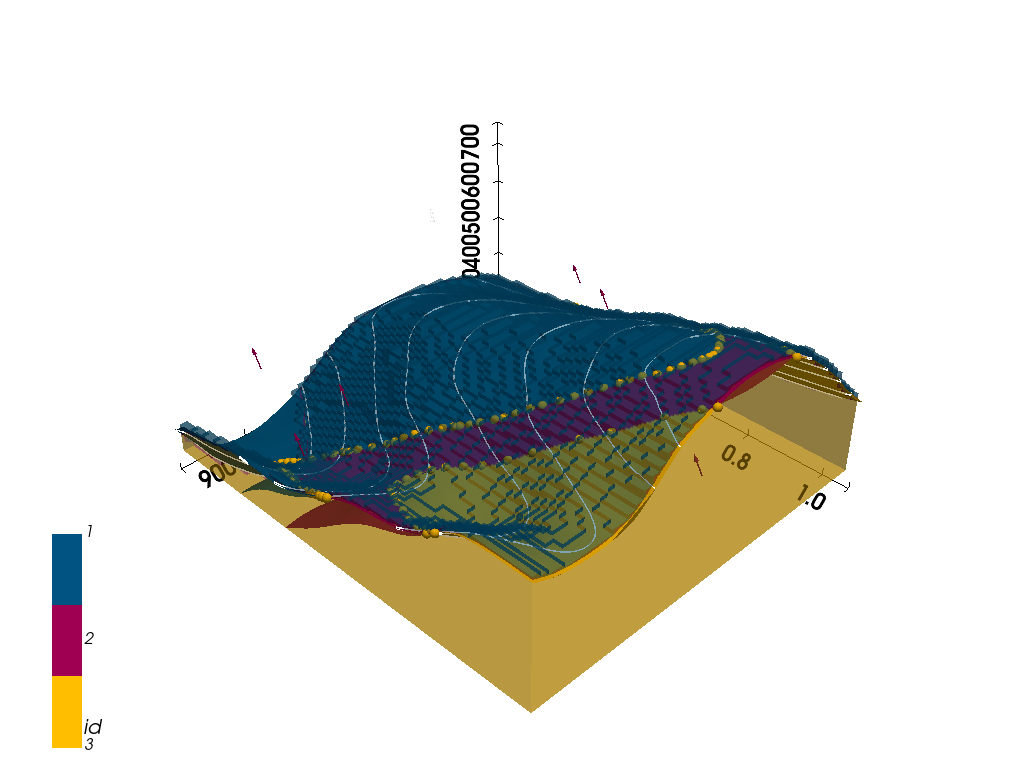

In [16]:
gpv = gp.plot_3d(geo_model, image=False, show_topography=True,
                 plotter_type='basic', notebook=True, show_lith=True)

## Extracting Shapefiles from Gempy model

Using the following code we are able to download the custom sections and the geological map as shapefiles

### Extracting GemPy Section Lines as Shapefiles

In [17]:
from shapely.geometry import LineString
gdf_sections = geo_model.grid.sections.df.copy(deep=True)
gdf_sections.reset_index()
linestrings = [LineString((gdf_sections.iloc[i]['start'],gdf_sections.iloc[i]['stop'] )) for i in range(len(gdf_sections))]
gdf_sections_new = gpd.GeoDataFrame(geometry=linestrings, data= gdf_sections.reset_index()[['index']], crs='EPSG:32632')
gdf_sections_new.to_file(file_path + 'test_sections.shp')

### Extracting GemPy Geological Map Polygons as Shapefiles

In [18]:
gdf = gg.postprocessing.extract_lithologies(geo_model, geo_model.grid.regular_grid.extent[:4], crs='EPSG:32632')
gdf.to_file(file_path + 'test.shp')

<img src="data/61_Exporting_geological_map_and_custom_sections_from_GemPy/test_files_QGIS.PNG" width=700 />